In [3]:
from math import sin,cos,pi,log,exp
import matplotlib.pyplot as plt
import numpy as np
import cfeplib

In [4]:
f=open('redtraj-5-1.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

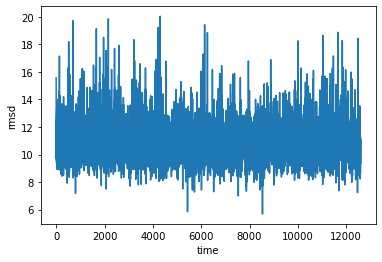

In [5]:
plt.plot(lrmsd[0:-1:100])
plt.xlabel('time')
_=plt.ylabel('rmsd')

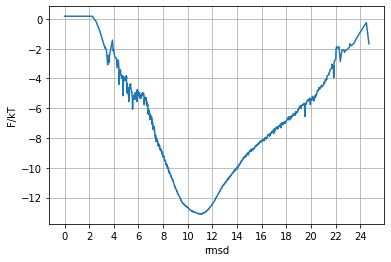

In [6]:
lx,lzh=cfeplib.comp_Zca(lrmsd,a=-1,dx=0.01,dt=1,strict=False)
lf=[-log(zh*2) for zh in lzh]

plt.plot(lx,lf)
plt.xticks(np.arange(0, 25, step=2))
plt.grid()
plt.xlabel('rmsd')
_=plt.ylabel('F/kT')


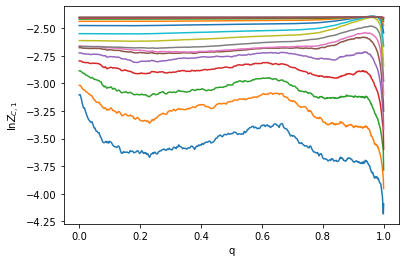

In [14]:
lq=cfeplib.to_committor(lrmsd,0.01,4,11)

ldt=[2**i for i in range(16)]
dx=0.001
for dt in ldt:
    ekn=cfeplib.comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=cfeplib.comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,-np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [15]:
def Nab_traj(lrmsd,a,b):
    il=None
    n=0
    for x in lrmsd:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=4
b=11
lx1,ly1=cfeplib.comp_Zca(lrmsd,a=1,dx=0.0001)
print (Nab_traj(lrmsd,a,b),Nab_model(lx1,ly1,a,b))

11.0 43.64312083084235


In [16]:
for dt in range(1,11):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 11.0 43.64312083084235
2 10.0 33.406126562289714
3 10.0 30.819010936007466
4 8.0 28.393434081388556
5 9.0 27.243084258414985
6 9.0 26.525111106802974
7 9.0 23.89020230816528
8 7.0 23.974667092220322
9 10.0 24.760510521252797
10 8.0 23.141899713816493


In [17]:
for dt in range(10,40):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

10 8.0 23.141899713816493
11 7.0 22.18520210614316
12 8.0 22.325372403326796
13 7.0 23.448205209305765
14 9.0 22.24898399700758
15 8.0 22.352965808654854
16 6.0 21.50299831406601
17 6.0 22.313250459207
18 9.0 21.93843935130629
19 6.0 20.761540564553442
20 7.0 21.377929207681472
21 7.0 21.082122093753178
22 7.0 19.99337491442862
23 7.0 20.69648037037221
24 6.0 20.672074306791647
25 7.0 20.294248489545364
26 6.0 19.411222858924813
27 6.0 18.8757064065737
28 7.0 19.221233158921663
29 6.0 18.955445514154924
30 7.0 19.30135065709313
31 8.0 20.21434810339994
32 6.0 20.243424216097146
33 6.0 19.578872824833795
34 6.0 19.729583895094052
35 5.0 19.654553676098327
36 7.0 18.22340587829613
37 8.0 20.599490017734
38 6.0 19.42321018993419
39 7.0 19.27715424102182


In [18]:
def fab_model(lrmsd,a,b,dx=0.001):
    lx,lzc1=cfeplib.comp_Zca(lrmsd,1,dx=dx)
    lx,lzh=cfeplib.comp_Zca(lrmsd,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(lrmsd)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(lrmsd,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(lrmsd):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
     
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(lrmsd,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(lrmsd,a,b))

model: NAB=43.6309, mfpt_AB=141.652, mftp_BA=28718, mtpt=71.1406
traj:  NAB=11, mfpt_AB=526.364, mftp_BA=109830, mtpt=153.909
